<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BManaus%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/manausdiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,27423.0,27423.000000,13554.000000,13302.000000,13362.000000,13273.000000,11607.000000,13311.000000,10790.000000,13298.000000,0.0
mean,82331.0,593.151734,6.345499,32.027665,23.672953,4.986710,2.776747,27.151021,81.584824,1.055825,NaN
std,0.0,599.971856,13.615974,2.238457,1.443480,3.331108,1.918301,1.597451,8.733961,0.760244,NaN
min,82331.0,0.000000,0.000000,20.300000,8.400000,0.000000,0.000000,11.400000,45.250000,0.000000,NaN
25%,82331.0,0.000000,0.000000,30.700000,22.800000,2.000000,1.500000,26.060000,76.000000,0.666667,NaN
50%,82331.0,0.000000,0.000000,32.300000,23.600000,5.000000,2.400000,27.080000,82.500000,1.000000,NaN
75%,82331.0,1200.000000,6.275000,33.500000,24.500000,7.900000,3.500000,28.160000,88.000000,1.371840,NaN
max,82331.0,1200.000000,155.000000,39.000000,31.100000,11.500000,27.200000,33.740000,100.000000,8.166667,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,82331,1980-01-01,0,NaN,31.4,NaN,4.9,1.6,26.66,87.75,1.200000,NaN
1,82331,1980-01-01,1200,13.2,NaN,24.1,NaN,NaN,NaN,NaN,NaN,NaN
2,82331,1980-01-02,0,NaN,28.4,NaN,2.1,3.8,24.76,94.75,1.333333,NaN
3,82331,1980-01-02,1200,0.0,NaN,22.4,NaN,NaN,NaN,NaN,NaN,NaN
4,82331,1980-01-03,0,NaN,32.2,NaN,5.5,0.7,25.34,90.25,1.766667,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,13302.000000,0.0,13273.000000,11607.000000,13311.000000,10790.000000,13298.000000
mean,NaN,32.027665,NaN,4.986710,2.776747,27.151021,81.584824,1.055825
std,NaN,2.238457,NaN,3.331108,1.918301,1.597451,8.733961,0.760244
min,NaN,20.300000,NaN,0.000000,0.000000,11.400000,45.250000,0.000000
25%,NaN,30.700000,NaN,2.000000,1.500000,26.060000,76.000000,0.666667
50%,NaN,32.300000,NaN,5.000000,2.400000,27.080000,82.500000,1.000000
75%,NaN,33.500000,NaN,7.900000,3.500000,28.160000,88.000000,1.371840
max,NaN,39.000000,NaN,11.500000,27.200000,33.740000,100.000000,8.166667


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,13554.000000,0.0,13362.000000,0.0,0.0,0.0,0.0,0.0
mean,6.345499,NaN,23.672953,NaN,NaN,NaN,NaN,NaN
std,13.615974,NaN,1.443480,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,8.400000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,22.800000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,23.600000,NaN,NaN,NaN,NaN,NaN
75%,6.275000,NaN,24.500000,NaN,NaN,NaN,NaN,NaN
max,155.000000,NaN,31.100000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,31.4,4.9,1.6,26.66,87.75,1.200000
1980-01-02,28.4,2.1,3.8,24.76,94.75,1.333333
1980-01-03,32.2,5.5,0.7,25.34,90.25,1.766667
1980-01-04,31.6,5.1,1.8,26.50,87.00,1.433333
1980-01-05,27.4,0.4,1.8,25.02,93.75,1.333333


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,13.2,24.1
1980-01-02,0.0,22.4
1980-01-03,10.8,22.1
1980-01-04,1.2,22.3
1980-01-05,2.7,22.1


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.4,4.9,1.6,26.66,87.75,1.200000,13.2,24.1
1980-01-02,28.4,2.1,3.8,24.76,94.75,1.333333,0.0,22.4
1980-01-03,32.2,5.5,0.7,25.34,90.25,1.766667,10.8,22.1
1980-01-04,31.6,5.1,1.8,26.50,87.00,1.433333,1.2,22.3
1980-01-05,27.4,0.4,1.8,25.02,93.75,1.333333,2.7,22.1


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,13302.000000,13273.000000,11607.000000,13311.000000,10790.000000,13298.000000,13554.000000,13362.000000
mean,32.027665,4.986710,2.776747,27.151021,81.584824,1.055825,6.345499,23.672953
std,2.238457,3.331108,1.918301,1.597451,8.733961,0.760244,13.615974,1.443480
min,20.300000,0.000000,0.000000,11.400000,45.250000,0.000000,0.000000,8.400000
25%,30.700000,2.000000,1.500000,26.060000,76.000000,0.666667,0.000000,22.800000
50%,32.300000,5.000000,2.400000,27.080000,82.500000,1.000000,0.000000,23.600000
75%,33.500000,7.900000,3.500000,28.160000,88.000000,1.371840,6.275000,24.500000
max,39.000000,11.500000,27.200000,33.740000,100.000000,8.166667,155.000000,31.100000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.4,4.9,1.6,26.66,87.75,1.200000,13.2,24.1
1980-01-02,28.4,2.1,3.8,24.76,94.75,1.333333,0.0,22.4
1980-01-03,32.2,5.5,0.7,25.34,90.25,1.766667,10.8,22.1
1980-01-04,31.6,5.1,1.8,26.50,87.00,1.433333,1.2,22.3
1980-01-05,27.4,0.4,1.8,25.02,93.75,1.333333,2.7,22.1


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,4.9,1.6,26.66,87.75,1.200000,13.2,24.1
1980-01-02,2.1,3.8,24.76,94.75,1.333333,0.0,22.4
1980-01-03,5.5,0.7,25.34,90.25,1.766667,10.8,22.1
1980-01-04,5.1,1.8,26.50,87.00,1.433333,1.2,22.3
1980-01-05,0.4,1.8,25.02,93.75,1.333333,2.7,22.1


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    31.4
1980-01-02    28.4
1980-01-03    32.2
1980-01-04    31.6
1980-01-05    27.4
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,13200.000000,11424.000000,13246.000000,10723.000000,12904.000000,13299.000000,13283.000000
mean,-0.132047,-0.798037,0.409606,0.327946,-0.746962,-0.917594,0.344854
std,0.579246,0.138769,0.142809,0.318735,0.181742,0.176735,0.126551
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.652174,-0.889706,0.312444,0.123288,-0.836735,-1.000000,0.268722
50%,-0.130435,-0.830882,0.401970,0.360731,-0.755102,-1.000000,0.339207
75%,0.373913,-0.742647,0.498657,0.561644,-0.668754,-0.918710,0.418502
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(13302, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 769.0682 - mean_absolute_error: 27.5342
Epoch 2/200
 - 1s - loss: 430.2836 - mean_absolute_error: 20.5431
Epoch 3/200
 - 1s - loss: 225.0525 - mean_absolute_error: 14.7492
Epoch 4/200
 - 1s - loss: 102.0977 - mean_absolute_error: 9.7641
Epoch 5/200
 - 1s - loss: 38.1024 - mean_absolute_error: 5.6979
Epoch 6/200
 - 1s - loss: 12.3944 - mean_absolute_error: 3.0243
Epoch 7/200
 - 1s - loss: 5.8284 - mean_absolute_error: 1.9621
Epoch 8/200
 - 1s - loss: 5.0202 - mean_absolute_error: 1.7621
Epoch 9/200
 - 1s - loss: 4.9876 - mean_absolute_error: 1.7412
Epoch 10/200
 - 1s - loss: 4.9881 - mean_absolute_error: 1.7400
Epoch 11/200
 - 1s - loss

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.896026, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.896026 (0.019980) {'batch_size': 10, 'camadas': 2, 'units': 7}


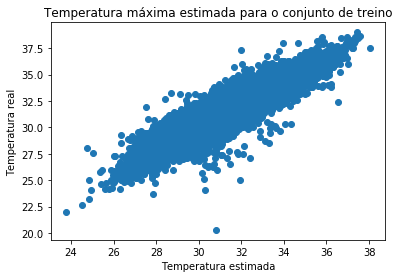

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.        0.9096709]
 [0.9096709 1.       ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

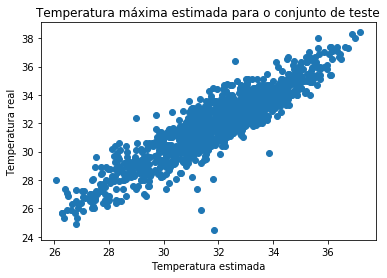

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.90489585]
 [0.90489585 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.7405408161372551


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

0.9301247536169077


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,31.4,4.9,1.6,26.66,87.75,1.200000,13.2
1980-01-02,28.4,2.1,3.8,24.76,94.75,1.333333,0.0
1980-01-03,32.2,5.5,0.7,25.34,90.25,1.766667,10.8
1980-01-04,31.6,5.1,1.8,26.50,87.00,1.433333,1.2
1980-01-05,27.4,0.4,1.8,25.02,93.75,1.333333,2.7


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    24.1
1980-01-02    22.4
1980-01-03    22.1
1980-01-04    22.3
1980-01-05    22.1
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,13283.000000,13255.000000,11433.000000,13293.000000,10772.000000,12964.000000,13361.000000
mean,0.254413,-0.132739,-0.798074,0.410596,0.327288,-0.746911,-0.917610
std,0.239411,0.579328,0.138711,0.142206,0.319045,0.181584,0.176358
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.112299,-0.652174,-0.889706,0.312444,0.123288,-0.836735,-1.000000
50%,0.283422,-0.130435,-0.830882,0.403760,0.360731,-0.755102,-1.000000
75%,0.411765,0.373913,-0.742647,0.500448,0.561644,-0.668754,-0.917419
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(13362, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 374.4394 - mean_absolute_error: 19.1493
Epoch 2/200
 - 1s - loss: 160.1563 - mean_absolute_error: 12.4641
Epoch 3/200
 - 1s - loss: 58.3967 - mean_absolute_error: 7.3931
Epoch 4/200
 - 1s - loss: 16.0281 - mean_absolute_error: 3.6545
Epoch 5/200
 - 1s - loss: 3.9786 - mean_absolute_error: 1.5950
Epoch 6/200
 - 1s - loss: 2.2135 - mean_absolute_error: 1.1346
Epoch 7/200
 - 1s - loss: 2.1161 - mean_absolute_error: 1.1126
Epoch 8/200
 - 1s - loss: 2.1137 - mean_absolute_error: 1.1125
Epoch 9/200
 - 1s - loss: 2.1138 - mean_absolute_error: 1.1130
Epoch 10/200
 - 1s - loss: 2.1137 - mean_absolute_error: 1.1124
Epoch 11/200
 - 1s - loss: 2.1144 - mean_absolute_error: 1.1131
Epoch 12/200
 - 1s - loss: 2.1150 - mean_absolute_error: 1.1129
Epoch 13/200
 - 1s - l

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.808732, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.808732 (0.032052) {'batch_size': 10, 'camadas': 2, 'units': 7}


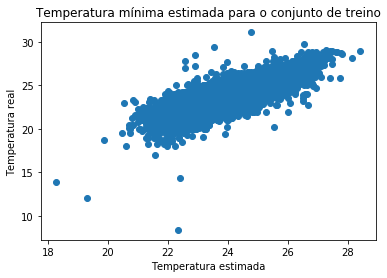

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.79194487]
 [0.79194487 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

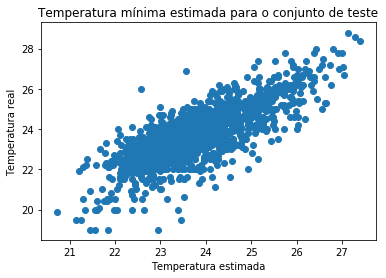

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.        0.7818233]
 [0.7818233 1.       ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.6657495888115849


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

0.7586192992775808


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaManaus.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaManaus.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))